In [64]:
import pandas as pd
import math

from collections import Counter
import operator
from tqdm.notebook import tqdm

import bittremieux_utils
from spectrum_utils.spectrum import MsmsSpectrum
from ms_io import ms_io


In [2]:
file_labels = '/media/maesk/WD/MS/PXD000561/kim2014_ids.csv'
labels = pd.read_csv(file_labels)
labels['sequence'] = labels['sequence'].str.replace('L', 'I')

cluster_labels = bittremieux_utils.get_clusters_falcon(
    '/media/maesk/WD/falcon/PXD000561/nn/' + \
        'fragm_tol_0.05_hash_len_800/prec_tol_20/clusters_eps_0.1_minsample_2.csv',
    labels
)

# Extract metadata from identifier
development = []
tissue = []
spectrometer = []

for id in cluster_labels['identifier'].tolist():
    _, _, id, _, _ = id.split(':')
    d, t, _, ms, _, _ = id.split('_')

    development.append(d)
    tissue.append(t)
    spectrometer.append(ms)

cluster_labels.insert(0, 'development', development)
cluster_labels.insert(1, 'spectrometer', spectrometer)
cluster_labels.insert(2, 'tissue', tissue)

In [3]:
def getMax(counter):
    maj_key = max(counter.items(), key=operator.itemgetter(1))[0]
    return maj_key, counter[maj_key]

def clusterType(ids):
    nsp_cl = len(ids)
    count = Counter(ids)

    # Get the key with larger count
    maj_key, _ = getMax(count)

    if (count[maj_key] > nsp_cl/2) and not pd.isna(maj_key):
        type = 'coherent_seq'
    elif count[maj_key] == nsp_cl and pd.isna(maj_key):
        type = 'unidentified'
    elif len(count) == 2: # All the identifications are similar
        type = 'converging'
    else:
        type = 'low_confidence'

    return type

def majTissue(tissues):
    nsp_cl = len(tissues)
    count = Counter(tissues)
    maj_tissue, cnt = getMax(count)
    return maj_tissue, cnt/nsp_cl

In [4]:
cluster_labels.sort_values(by='cluster', inplace=True)
cluster_labels.reset_index(drop=True, inplace=True)
cluster_labels.to_csv('/media/maesk/WD/test.csv')

In [27]:
import numpy as np
import time

nclusters = max(cluster_labels['cluster'])
clids = []
cltypes = []
clsizes = []
maj_tissues = []
prop_maj_tissues = []

curr_cluster = 0

clids = []
curr_sequences = []
curr_tissues = []
curr_size = 0

# Iterate over the dataframe
for index, row in tqdm(cluster_labels.iterrows()):
    if row['cluster'] == -1:
        continue

    if curr_cluster != row['cluster']:
        cltypes.append(clusterType(curr_sequences))
        clsizes.append(curr_size)
        maj_tissue, prop_maj_tissue = majTissue(curr_tissues)
        maj_tissues.append(maj_tissue)
        prop_maj_tissues.append(prop_maj_tissue)

        clids.append(curr_cluster)
        curr_sequences = []
        curr_tissues = []
        curr_size = 0
        curr_cluster = curr_cluster + 1

        assert curr_cluster == row['cluster'] # Clusters should be ordered

    curr_sequences.append(row['sequence'])
    curr_tissues.append(row['tissue'])
    curr_size = curr_size + 1

|          | 0/? [00:00<?, ?it/s]

In [28]:
cl_summary = pd.DataFrame({'id': clids, 'type':cltypes, 'size': clsizes,
                           'maj_tissue': maj_tissues, 'prop_maj_tissue': prop_maj_tissues
                           })
cl_summary.sort_values(by='size', ascending=False).to_csv('summary_PXD0000561.csv')


In [25]:
mask = cluster_labels['cluster'] == 17
cluster_labels[mask]

,development,spectrometer,tissue,identifier,precursor_charge,precursor_mz,cluster,sequence
10986010,Adult,Elite,Heart,mzspec:PXD000561:Adult_Heart_bRP_Elite_81_f08:...,2,300.150513,17,NaN
10986011,Adult,Elite,Heart,mzspec:PXD000561:Adult_Heart_bRP_Elite_81_f10:...,2,300.150299,17,NaN


In [26]:
cl_summary[cl_summary['id'] == 17]


,id,type,size,maj_tissue,prop_maj_tissue
16,17,unidentified,9,Gut,1.0


### Export the clusters satisfying the condition

In [80]:
def scorer_peaks_pairs(mzs, intensities, w):
    assert len(mzs) == 2
    assert len(intensities) == 2
    assert len(w) == 2

    av_intensity = (intensities[0]/w[0] + intensities[1]/w[1]) / 2
    return abs( av_intensity /(mzs[1]-mzs[0]))


def representative_spectrum(sps, consensus_identifier, min_intensity=0.01, max_num_peaks=50, tol=0.05):
    nsp = len(sps)

    # Get all the peaks
    peaks = []
    for i in range(nsp):
        sp = sps[i]
        peaks = peaks + \
                    [(mz, intensity, 1) for mz, intensity in zip(sp.mz, sp.intensity)]
                    # (peak mz, peak intensity, number of spectra having the peak)

    # Merge the pairs of peaks with best scores (depends on distance between peaks and intensity)
    while True:
        peaks.sort()    # Sort by increasing mz
        pair_scores = []

        for i in range(len(peaks)-1):
            for j in range(i+1, len(peaks)):
                if peaks[j][0] - peaks[i][0] > tol: # Always positive because ordered
                    break
                else:
                    score = scorer_peaks_pairs(
                        [peaks[i][0], peaks[j][0]], # m/z
                        [peaks[i][1], peaks[j][1]], # intensity
                        [peaks[i][2], peaks[j][2]]  # weights
                    )
                    pair_scores.append( (score, (i,j)) )

        if len(pair_scores) == 0: # No more peaks can be merged
            # Scale the peaks according to the probability they appear in a spectrum
            # see Frank et al. https://pubs.acs.org/doi/abs/10.1021/pr070361e?casa_token=s05YEJTDKdsAAAAA:EEPc2E5byfAfCZtat1j4r65xOh5vFLtohaP0Zvs5cLuYZxZSN3axNyVBrk7dKzANbB69IFtHeHiX1ACp
            scaled_peaks = []

            for p in peaks:
                prob = p[2] / nsp
                scaled_peaks.append( (p[0], p[1] * (0.95 + 0.05*(1+prob)**5)) )

            return MsmsSpectrum(
                consensus_identifier,
                np.average([sp.precursor_mz for sp in sps]),
                sps[0].precursor_charge,
                [p[0] for p in scaled_peaks],
                [p[1] for p in scaled_peaks]
            ).filter_intensity(min_intensity, max_num_peaks)

        # Merge the pair having the highest score
        pair_scores.sort(reverse=True)
        i = pair_scores[0][1]   # Peaks indices
        p = peaks[i[0]], peaks[i[1]]
        new_mz = (p[0][2]*p[0][0] + p[1][2]*p[1][0]) / (p[0][2] + p[1][2])
        new_peak = (new_mz, p[0][1] + p[1][1], p[0][2] + p[1][2])

        # Update the list of peaks
        peaks.remove(p[0])
        peaks.remove(p[1])
        peaks.append(new_peak)



In [60]:
mask = (cl_summary['type'] == 'unidentified') & \
       (cl_summary['prop_maj_tissue'] == 1) & (cl_summary['size'] > 3)
print('Number of large unidentified clusters: %d' % (sum(mask),))
cl_summary[mask].sort_values(by='size', ascending=False)

Number of large unidentified clusters: 37340


,id,type,size,maj_tissue,prop_maj_tissue
643474,643474,unidentified,240,Gut,1.0
573261,573261,unidentified,189,NKcells,1.0
510811,510811,unidentified,143,Brain,1.0
613112,613112,unidentified,142,Heart,1.0
992160,992160,unidentified,141,Heart,1.0
...,...,...,...,...,...
853900,853900,unidentified,4,Gallbladder,1.0
853905,853905,unidentified,4,Prostate,1.0
381207,381207,unidentified,4,Heart,1.0
381204,381204,unidentified,4,Heart,1.0


  0%|          | 0/37340 [00:00<?, ?it/s]

16 9
['mzspec:PXD000561:Fetal_Gut_bRP_Elite_18_f24:scan:4754', 'mzspec:PXD000561:Fetal_Gut_bRP_Elite_17_f23:scan:7396', 'mzspec:PXD000561:Fetal_Gut_bRP_Elite_17_f24:scan:7142', 'mzspec:PXD000561:Fetal_Gut_bRP_Elite_18_f23:scan:5567', 'mzspec:PXD000561:Fetal_Gut_bRP_Elite_17_f24:scan:7289', 'mzspec:PXD000561:Fetal_Gut_bRP_Elite_18_f24:scan:4911', 'mzspec:PXD000561:Fetal_Gut_bRP_Elite_18_f23:scan:5420', 'mzspec:PXD000561:Fetal_Gut_bRP_Elite_17_f23:scan:7529', 'mzspec:PXD000561:Fetal_Gut_bRP_Elite_17_f23:scan:7260']
554602.2 675292.4


<ipython-input-80-33df3c1961cf>:7: RuntimeWarning: divide by zero encountered in double_scalars
  return abs( av_intensity /(mzs[1]-mzs[0]))


[129.08972 130.0748  140.05457 143.08563 144.0804  154.0652  156.08632
 157.08458 167.06543 170.0643  171.09167 173.11116 175.11891 182.06813
 185.07602 197.08849 199.08679 200.08878 211.10211 213.12154 254.13579
 255.145   269.12436 272.16806 279.10748 282.13522 283.10468 286.15213
 291.6419  299.16125 300.14413 304.1614  307.10352 313.16345 324.12863
 341.15652 342.14862 359.16708 397.17145 401.21387 411.19818 427.19272
 439.18835 456.21954]
[120.080444 129.10211  130.06506  130.08617  136.07571  140.03421
 141.06577  143.0729   144.08072  145.07593  145.0837   147.1127
 154.06503  156.0809   157.06047  157.10823  158.09225  167.04498
 167.09183  169.0605   169.07574  170.05994  171.0916   173.10716
 175.11882  182.05994  185.05563  185.1029   187.07106  192.10564
 197.07037  197.09741  199.0864   200.09149  202.1069   206.10252
 209.09131  211.10732  213.12312  216.1223   219.6083   220.10782
 223.08182  227.61299  228.14543  234.10562  236.10307  243.11014
 250.15364  251.113    25

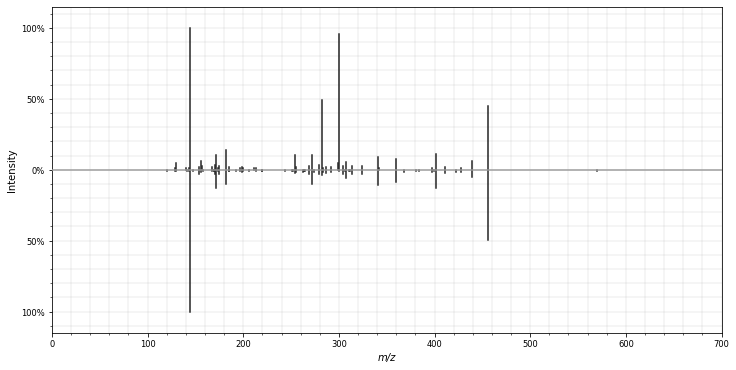

65 6
['mzspec:PXD000561:Adult_Kidney_Gel_Elite_55_f13:scan:520', 'mzspec:PXD000561:Adult_Kidney_Gel_Elite_55_f05:scan:467', 'mzspec:PXD000561:Adult_Kidney_Gel_Elite_55_f15:scan:513', 'mzspec:PXD000561:Adult_Kidney_Gel_Elite_55_f03:scan:559', 'mzspec:PXD000561:Adult_Kidney_Gel_Elite_55_f07:scan:539', 'mzspec:PXD000561:Adult_Kidney_Gel_Elite_55_f11:scan:494']
25671.967 21640.71


<ipython-input-80-33df3c1961cf>:7: RuntimeWarning: divide by zero encountered in double_scalars
  return abs( av_intensity /(mzs[1]-mzs[0]))


[110.07218 111.07399 112.07815 114.09838 115.08687 116.0709  121.04528
 122.07163 123.07135 130.08069 136.06943 138.06673 141.08458 148.08234
 150.06677 157.10478 158.09302 159.10573 164.10977 166.07993 167.08638
 168.09659 175.11958 176.10411 178.07074 187.10834 193.10907 194.1117
 195.08832 196.09142 203.10168 204.08165 209.12234 221.104   222.09926
 227.11458 237.13533 239.11464 244.15141 245.1248  249.1354  249.64359
 262.15182 274.1619  296.17273 326.1833  343.2098  344.20276 361.2205
 362.22394]
[110.07157  110.59121  111.055595 111.07494  111.09217  112.051186
 112.08725  113.071236 113.09072  114.09202  114.10302  115.08696
 116.07098  117.07433  117.23148  117.68541  119.63211  120.05589
 121.04012  122.071724 123.068596 123.075066 123.092476 125.07142
 125.5901   127.08717  129.10301  129.11435  130.06166  130.09805
 132.82231  134.07181  136.05116  136.08788  137.07155  138.06685
 139.07051  139.08716  140.08258  141.06645  141.10284  142.09795
 143.08244  143.10153  148.087

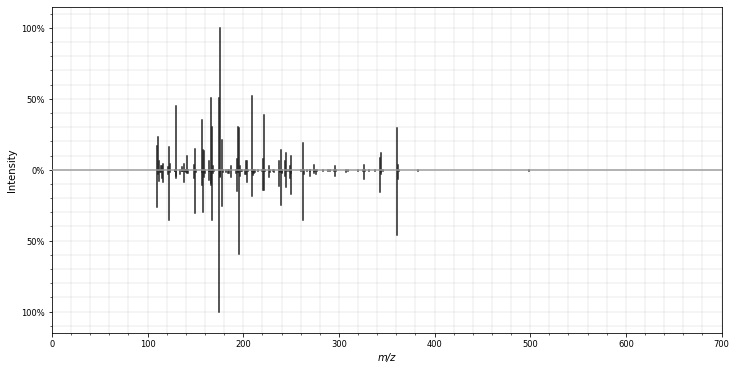

81 8
['mzspec:PXD000561:Adult_Heart_bRP_Elite_81_f02:scan:4268', 'mzspec:PXD000561:Adult_Heart_bRP_Elite_81_f07:scan:4772', 'mzspec:PXD000561:Adult_Heart_bRP_Elite_81_f04:scan:4389', 'mzspec:PXD000561:Adult_Heart_bRP_Elite_81_f02:scan:4341', 'mzspec:PXD000561:Adult_Heart_bRP_Elite_81_f05:scan:4282', 'mzspec:PXD000561:Adult_Heart_bRP_Elite_81_f03:scan:4456', 'mzspec:PXD000561:Adult_Heart_bRP_Elite_81_f15:scan:4194', 'mzspec:PXD000561:Adult_Heart_bRP_Elite_81_f06:scan:4704']
2378.9985 1846.6013


<ipython-input-80-33df3c1961cf>:7: RuntimeWarning: divide by zero encountered in double_scalars
  return abs( av_intensity /(mzs[1]-mzs[0]))


[110.06755  120.080894 129.09343  142.12291  166.0615   223.1557
 234.12405  251.15065  257.13995  277.16675  285.13516  299.1774
 300.19547  307.17694  324.14606  342.15656  370.15143  398.21957
 413.19415  454.2464   455.24066 ]
[110.060005 110.07113  115.64343  116.04455  120.080734 121.092995
 121.988304 128.28581  129.06607  129.10228  130.08635  136.0757
 138.06624  142.1227   142.28871  145.09718  147.11285  153.06601
 155.23566  166.06125  169.09763  175.11916  176.51637  178.13382
 180.07669  183.11328  187.08682  196.14471  197.12897  197.42816
 204.32863  205.09732  206.00052  208.07208  215.00902  221.33545
 223.15555  224.13965  226.70952  232.66284  233.17622  234.12372
 244.16571  251.15039  257.13968  260.19702  270.18204  277.16647
 279.18222  285.13522  289.16678  293.41733  299.1099   299.17236
 299.2353   299.29385  300.16837  300.21744  300.238    307.1764
 312.43945  313.12927  324.1456   338.18237  339.12527  339.1671
 339.18564  342.1552   349.81223  357.25046  

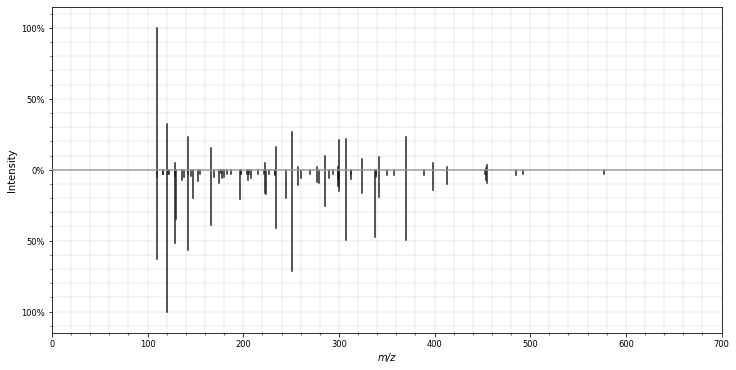

117 4
['mzspec:PXD000561:Adult_Heart_Gel_Elite_54_f03:scan:1273', 'mzspec:PXD000561:Adult_Heart_Gel_Elite_54_f04:scan:1275', 'mzspec:PXD000561:Adult_Heart_Gel_Elite_54_f06:scan:1474', 'mzspec:PXD000561:Adult_Heart_Gel_Elite_54_f02:scan:1161']
39891.64 19489.82


<ipython-input-80-33df3c1961cf>:7: RuntimeWarning: divide by zero encountered in double_scalars
  return abs( av_intensity /(mzs[1]-mzs[0]))


[110.070496 129.0935   130.08388  136.07666  147.10564  166.07913
 167.09822  175.1092   187.12576  193.10431  195.08954  196.12033
 204.12877  209.10034  211.12115  212.12662  213.12022  221.10121
 222.10767  223.1453   226.12346  230.14473  239.11131  240.12247
 244.14662  248.1601   249.65489  251.14026  261.14008  269.64078
 282.1506   290.15247  291.1556   299.1531   300.17078  334.1745
 352.1972   361.2438   453.23914  498.3023  ]
[110.07075  111.05436  111.07388  111.091125 112.086464 113.07051
 114.60638  116.603516 119.04873  120.0803   121.03918  122.07083
 125.10695  127.08616  128.0697   129.10184  130.08583  130.08942
 130.60194  136.05006  136.07527  136.08685  138.06578  139.08597
 141.06535  142.12228  143.1175   143.92691  145.09772  147.11243
 150.06592  152.10641  154.08575  155.08093  155.1175   156.07617
 157.06047  157.09644  157.10802  158.09187  162.60475  162.87607
 166.06067  166.09721  167.09229  167.11731  169.06009  169.09668
 169.13292  171.076    173.1282

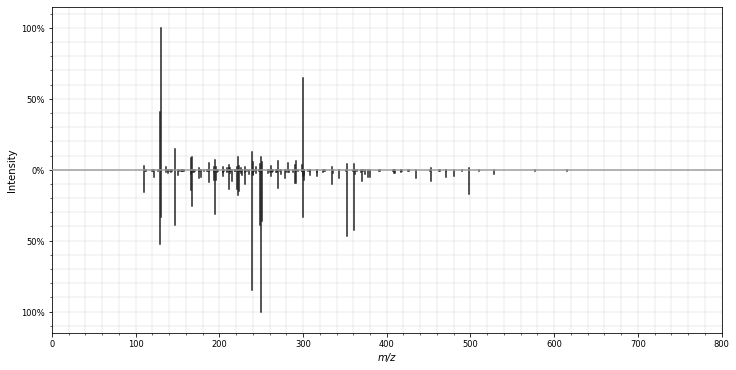

137 6
['mzspec:PXD000561:Adult_Urinarybladder_Gel_Elite_40_f23:scan:8421', 'mzspec:PXD000561:Adult_Urinarybladder_Gel_Elite_40_f20:scan:12057', 'mzspec:PXD000561:Adult_Urinarybladder_Gel_Elite_40_f20:scan:12199', 'mzspec:PXD000561:Adult_Urinarybladder_Gel_Elite_40_f21:scan:12348', 'mzspec:PXD000561:Adult_Urinarybladder_Gel_Elite_40_f16:scan:12093', 'mzspec:PXD000561:Adult_Urinarybladder_Gel_Elite_40_f19:scan:12885']
391025.94 462393.88


<ipython-input-80-33df3c1961cf>:7: RuntimeWarning: divide by zero encountered in double_scalars
  return abs( av_intensity /(mzs[1]-mzs[0]))


[112.100464 114.07323  116.07047  124.03919  130.08278  141.07802
 142.07846  153.07498  158.09242  159.08028  175.11893  181.13908
 185.09494  197.15964  199.14403  200.13933  207.1471   209.12643
 211.17136  215.13548  227.13892  237.12315  239.1627   255.13008
 257.16074  274.18726  277.66852  286.1808   299.15665  300.1583
 300.21387  387.27115  397.25534  399.27087  413.28653  499.287
 528.3135  ]
[110.05978  112.08671  112.11179  112.28651  113.0707   114.05471
 114.10246  114.70437  115.08645  115.1509   116.07046  120.190475
 124.03922  124.42385  128.07068  128.20341  129.08656  130.09744
 130.84668  131.78658  132.70836  137.57237  140.0706   141.06583
 141.10233  142.05002  142.09747  144.08075  145.0972   152.10718
 153.06566  153.10217  154.4343   157.10828  158.09242  159.0765
 167.08122  169.16954  171.5348   172.10826  172.17854  174.94072
 175.11893  176.12236  181.13338  185.0921   185.16502  189.1023
 197.16498  198.11206  199.14397  199.2496   200.13936  200.64082
 

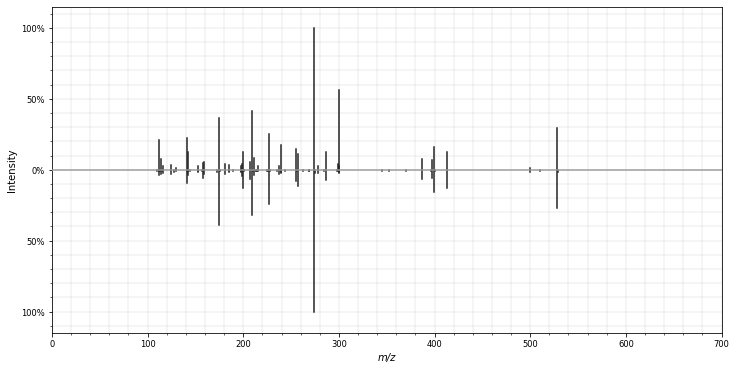

151 4
['mzspec:PXD000561:Adult_Urinarybladder_Gel_Elite_40_f23:scan:3056', 'mzspec:PXD000561:Adult_Urinarybladder_Gel_Elite_40_f24:scan:2889', 'mzspec:PXD000561:Adult_Urinarybladder_Gel_Elite_40_f24:scan:2964', 'mzspec:PXD000561:Adult_Urinarybladder_Gel_Elite_40_f24:scan:2814']
38141.973 20025.703


<ipython-input-80-33df3c1961cf>:7: RuntimeWarning: divide by zero encountered in double_scalars
  return abs( av_intensity /(mzs[1]-mzs[0]))


[299.1206  300.11185 300.1905  301.10046]
[110.05969  110.07115  110.09603  112.08655  112.11176  113.07065
 113.32013  113.690056 114.05479  114.102165 115.08651  116.07038
 117.35481  118.086205 120.080505 121.07572  124.11189  124.69321
 126.06608  127.05016  127.08637  128.07048  128.10696  129.10202
 130.04974  130.08606  130.0974   134.99306  136.0756   136.7811
 137.10722  138.05481  138.06584  140.08168  140.1069   141.06567
 141.10213  142.0971   143.11774  144.10162  144.12105  146.07085
 147.11288  148.25232  150.60521  151.04962  152.0817   152.10677
 152.75063  155.08145  155.11807  156.07649  157.10864  157.13339
 158.06007  158.09225  159.09593  164.08151  166.0861   167.09253
 167.11757  167.58887  168.10272  168.11273  168.12094  169.10812
 169.13348  170.0921   171.07634  171.11281  175.11876  176.12228
 179.11763  179.6076   180.07649  180.10191  181.13347  182.1287
 183.07709  183.11252  183.1488   185.08147  185.10316  187.08638
 187.10701  190.1076   194.1008   19

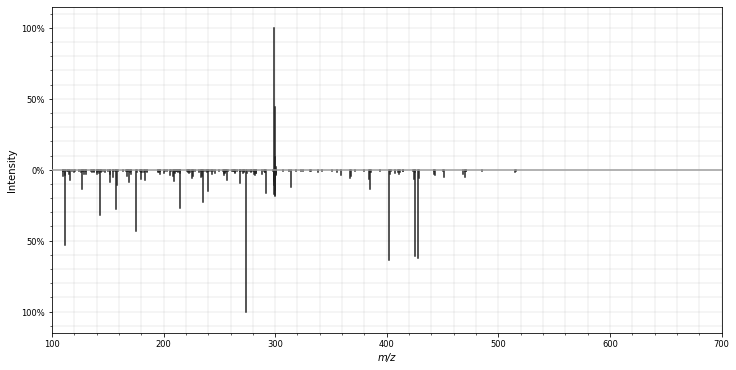

158 4
['mzspec:PXD000561:Adult_Urinarybladder_Gel_Elite_40_f16:scan:5750', 'mzspec:PXD000561:Adult_Urinarybladder_Gel_Elite_40_f22:scan:6455', 'mzspec:PXD000561:Adult_Urinarybladder_Gel_Elite_40_f16:scan:8207', 'mzspec:PXD000561:Adult_Urinarybladder_Gel_Elite_40_f16:scan:5884']
323036.16 203197.6


<ipython-input-80-33df3c1961cf>:7: RuntimeWarning: divide by zero encountered in double_scalars
  return abs( av_intensity /(mzs[1]-mzs[0]))


[110.06262  112.096695 128.08266  130.08435  142.0975   152.09698
 155.08675  167.089    173.09207  175.11256  183.1179   195.14186
 211.16507  215.11235  223.14401  232.13863  235.65955  239.16226
 241.15457  254.13333  272.15936  282.1511   299.13535  300.12735
 300.1839   314.18207  331.20856  444.29224  470.30795 ]
[110.011185 110.06     110.07116  111.45266  112.086876 112.112015
 113.07073  114.091354 114.10246  115.08656  116.07061  117.116745
 117.31742  120.08077  120.427795 120.94904  123.545296 125.0711
 125.10813  126.054955 127.086426 128.07066  129.06607  129.10237
 130.08635  130.09753  136.076    137.07103  138.05492  138.0667
 139.08672  140.08188  140.10774  141.06644  141.56317  142.09763
 147.11314  152.08202  152.10716  153.06592  153.08517  153.10262
 153.23225  154.08577  155.08173  156.06558  157.1086   158.09262
 158.59166  165.06596  167.04634  167.08174  167.1184   167.59795
 169.13345  170.11751  171.07655  172.10872  173.09225  175.1192
 176.12259  179.1167

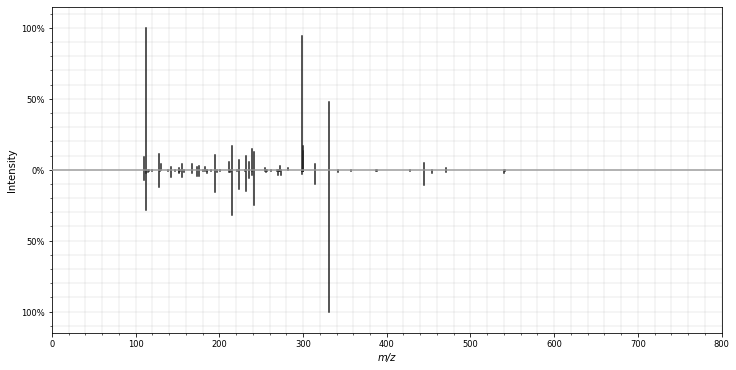

238 5
['mzspec:PXD000561:Adult_Liver_Gel_Elite_83_f12:scan:7054', 'mzspec:PXD000561:Adult_Liver_bRP_Elite_82_f08:scan:7668', 'mzspec:PXD000561:Adult_Liver_Gel_Elite_83_f14:scan:6354', 'mzspec:PXD000561:Adult_Liver_bRP_Elite_82_f07:scan:6676', 'mzspec:PXD000561:Adult_Liver_bRP_Elite_82_f06:scan:6731']
6967.452 187102.38


<ipython-input-80-33df3c1961cf>:7: RuntimeWarning: divide by zero encountered in double_scalars
  return abs( av_intensity /(mzs[1]-mzs[0]))


[112.09548  113.084724 115.072975 116.06732  120.08076  126.08822
 129.09683  130.08061  136.07755  141.10239  143.10736  146.07843
 147.10915  155.09686  156.1027   157.114    158.09253  159.08904
 169.11737  171.11293  175.11908  181.10341  187.12239  197.13084
 199.10191  199.18063  215.13196  227.16357  243.14536  253.16336
 271.16992  272.15546  288.20325  294.17688  299.15143  299.21512
 300.13385  300.19077  312.1835   384.26028  401.28708  435.271
 458.30844  459.25552  484.3241   485.3076   486.28818  502.33472
 503.33807  512.3193  ]
[110.071014 112.0867   112.11191  113.070595 114.10221  115.08637
 116.070305 119.049164 120.08066  126.09132  126.12758  129.1021
 130.06497  130.0862   136.07564  140.08188  141.10237  142.12263
 143.11783  147.11272  148.11194  152.10704  156.11314  157.13351
 158.09239  169.13344  171.1127   175.11888  181.09702  187.10735
 187.14394  197.12836  199.10738  199.18037  211.09438  215.1389
 223.09456  226.11903  233.16444  242.1859   246.18117  

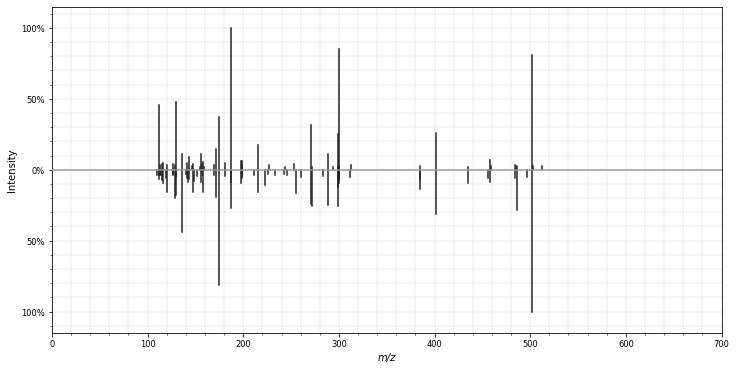

241 5
['mzspec:PXD000561:Adult_Bcells_bRP_Elite_75_f10:scan:520', 'mzspec:PXD000561:Adult_Bcells_Gel_Elite_76_f17:scan:438', 'mzspec:PXD000561:Adult_Bcells_Gel_Elite_76_f18:scan:501', 'mzspec:PXD000561:Adult_Bcells_Gel_Elite_76_f17:scan:567', 'mzspec:PXD000561:Adult_Bcells_Gel_Elite_76_f18:scan:432']
11186.712 5777.4624


<ipython-input-80-33df3c1961cf>:7: RuntimeWarning: divide by zero encountered in double_scalars
  return abs( av_intensity /(mzs[1]-mzs[0]))


[127.11675 128.07037 129.10208 130.09473 141.09612 143.11778 147.11269
 155.11777 169.11078 171.11261 200.13911 209.12402 226.14432 227.14426
 228.15207 240.15991 242.16782 244.16519 254.15646 256.16528 264.67834
 275.19308 277.68628 299.18585 300.1671  301.18665 353.21387 354.24927
 355.22955 367.23334 372.25992 384.25998 429.28085 471.3176  483.3281 ]
[110.09616  111.91912  113.1071   113.35766  115.08645  116.07036
 122.14546  123.973206 127.086464 127.12275  127.6984   128.07042
 129.10211  130.08607  130.10538  132.14911  132.88292  133.26416
 136.03795  141.06593  141.10223  142.0859   142.10558  143.11781
 147.11272  153.1022   155.11784  157.13376  158.06435  159.11243
 159.56114  161.72256  166.53947  166.5608   167.0929   168.11284
 169.09703  171.1127   172.76646  173.09169  173.12823  175.11864
 175.12593  179.11806  179.15353  181.13333  183.11215  184.12057
 185.12683  186.12343  187.10771  189.57472  193.34456  195.11275
 197.12839  200.13916  201.14233  204.13397  205.6

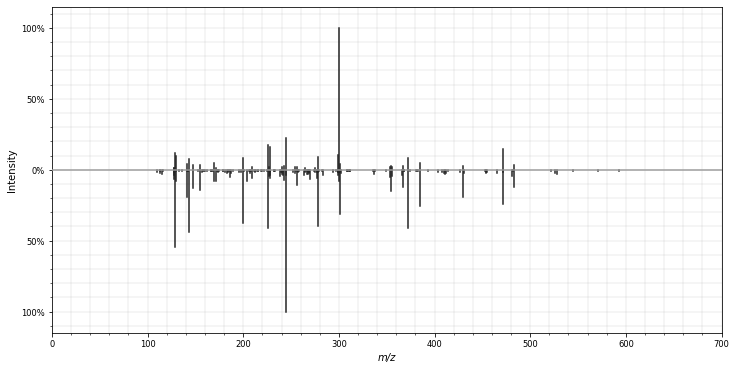

322 5
['mzspec:PXD000561:Adult_Heart_bRP_Elite_81_f18:scan:4201', 'mzspec:PXD000561:Adult_Heart_Gel_Elite_54_f03:scan:3546', 'mzspec:PXD000561:Adult_Heart_Gel_Elite_54_f02:scan:3089', 'mzspec:PXD000561:Adult_Heart_bRP_Elite_81_f17:scan:4377', 'mzspec:PXD000561:Adult_Heart_bRP_Elite_81_f19:scan:4525']
42708.95 19087.303


<ipython-input-80-33df3c1961cf>:7: RuntimeWarning: divide by zero encountered in double_scalars
  return abs( av_intensity /(mzs[1]-mzs[0]))


[110.07117  120.076614 128.07065  129.09174  130.07771  131.07979
 132.08083  142.08234  144.08087  147.11296  156.07689  158.06935
 159.08934  166.06119  170.06017  175.1082   185.16489  212.11426
 213.13498  257.14578  258.1441   268.10822  269.13177  277.13028
 278.15237  285.13464  288.1762   296.1718   297.14984  300.10883
 300.18973  301.1287   303.145    425.2295   443.24008  469.21902 ]
[110.07087  110.4975   111.091156 112.086464 113.10701  115.05363
 116.070366 118.06477  119.04907  120.08044  121.08373  122.07104
 124.06452  124.086525 125.45145  127.08643  128.07037  129.06549
 129.10194  130.06483  130.08595  131.04897  131.06822  131.11757
 132.08049  133.08395  134.09618  136.07526  136.77252  138.06606
 139.08606  140.07014  141.10191  142.06462  142.08601  142.09723
 143.11768  144.08052  147.11256  148.2144   148.58946  150.06593
 154.06078  155.08118  155.093    156.07642  157.09686  157.13353
 158.05977  158.09221  159.06285  159.09132  159.11243  162.09079
 166.060

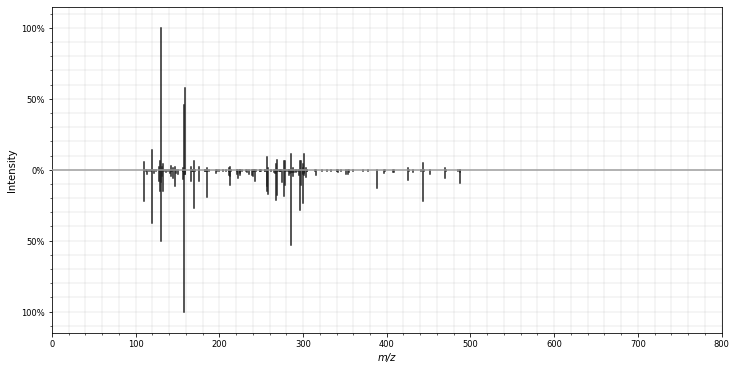

335 5
['mzspec:PXD000561:Adult_Platelets_Gel_Elite_48_f01:scan:267', 'mzspec:PXD000561:Adult_Platelets_Gel_Elite_48_f12:scan:70', 'mzspec:PXD000561:Adult_Platelets_Gel_Elite_48_f12:scan:12', 'mzspec:PXD000561:Adult_Platelets_Gel_Elite_48_f01:scan:207', 'mzspec:PXD000561:Adult_Platelets_Gel_Elite_48_f01:scan:146']
58062.066 41117.75


<ipython-input-80-33df3c1961cf>:7: RuntimeWarning: divide by zero encountered in double_scalars
  return abs( av_intensity /(mzs[1]-mzs[0]))


[112.081764 129.08405  130.09625  139.07045  141.08607  157.09729
 158.09245  167.10674  175.11896  187.05902  195.11884  222.12363
 223.10925  236.63065  240.13046  245.14684  269.13712  270.1684
 283.15594  291.65833  300.1119   300.1779   300.66257  301.16528
 303.18903  304.1613   326.14578  343.1726   344.1619   361.18277
 362.18616  416.2614   426.21637  499.25684 ]
[110.070854 111.091286 112.0754   112.08649  113.07087  114.10235
 115.08618  116.070435 118.74542  119.4899   123.64164  124.34024
 126.05476  127.35251  129.06563  129.10199  130.08597  130.09758
 130.10529  133.09683  139.05023  139.08627  141.0656   141.10205
 143.11752  147.11267  152.02885  152.08167  152.1171   157.09703
 158.09215  159.07637  165.68442  167.04536  167.09297  167.11787
 168.1131   172.07205  175.11867  176.12181  177.10187  181.05998
 181.90176  183.11229  183.14847  185.10323  186.9845   187.07109
 195.11241  195.34097  195.73157  196.10762  197.16444  207.06952
 211.10794  214.11827  222.1231

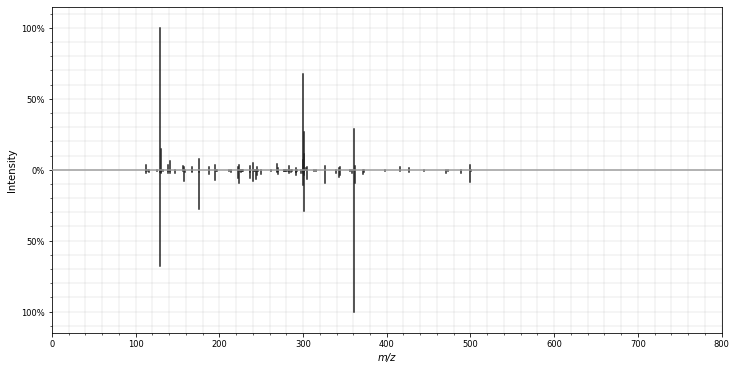

360 6
['mzspec:PXD000561:Adult_Adrenalgland_Gel_Elite_49_f19:scan:1668', 'mzspec:PXD000561:Adult_Adrenalgland_Gel_Elite_49_f20:scan:1741', 'mzspec:PXD000561:Adult_Adrenalgland_Gel_Elite_49_f08:scan:1710', 'mzspec:PXD000561:Adult_Adrenalgland_Gel_Elite_49_f09:scan:1729', 'mzspec:PXD000561:Adult_Adrenalgland_Gel_Elite_49_f21:scan:1800', 'mzspec:PXD000561:Adult_Adrenalgland_Gel_Elite_49_f10:scan:1895']
34485.0 21909.592


<ipython-input-80-33df3c1961cf>:7: RuntimeWarning: divide by zero encountered in double_scalars
  return abs( av_intensity /(mzs[1]-mzs[0]))


[110.074066 129.09323  130.08995  143.11801  147.10774  155.09387
 171.1181   175.11221  181.10925  204.1344   209.10147  300.12674
 300.1855   301.15512  412.21893 ]
[110.07118  111.074814 112.08673  113.07088  115.08671  116.07088
 120.080956 127.08664  128.07092  129.06602  129.1023   130.08629
 131.08151  136.0757   139.087    141.1024   143.11801  147.07646
 147.11295  151.08675  151.09753  155.08167  155.11824  156.0769
 157.06085  157.13367  158.09267  159.07675  166.06137  169.09718
 171.11296  172.10788  173.09224  173.1286   175.07083  175.11911
 176.12239  179.08148  181.09737  183.07678  183.11287  185.12825
 186.1238   187.10796  191.08109  195.14929  196.10791  197.12839
 198.12349  199.1078   201.10217  201.12321  204.13438  206.12665
 206.61322  208.65265  209.09216  210.08691  214.1182   215.13908
 223.14407  224.10306  226.1189   227.10255  228.09802  228.13382
 235.1474   240.13458  241.11783  242.11317  243.134    245.12462
 246.10756  252.10876  252.14563  260.1963

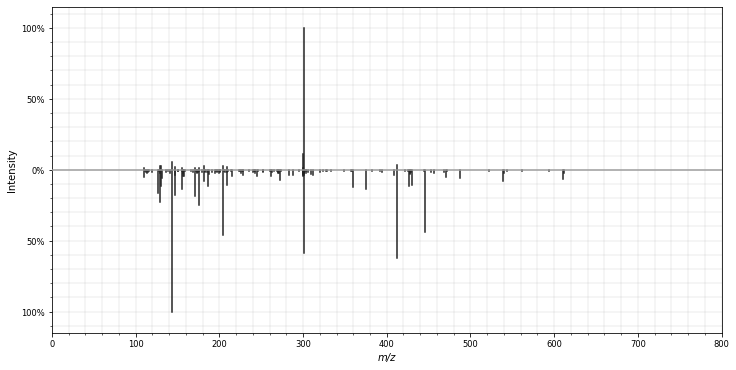

436 4
['mzspec:PXD000561:Adult_Liver_Gel_Elite_83_f18:scan:4490', 'mzspec:PXD000561:Adult_Liver_Gel_Elite_83_f16:scan:4528', 'mzspec:PXD000561:Adult_Liver_Gel_Elite_83_f17:scan:4596', 'mzspec:PXD000561:Adult_Liver_Gel_Elite_83_f14:scan:4388']
33390.215 11729.781


<ipython-input-80-33df3c1961cf>:7: RuntimeWarning: divide by zero encountered in double_scalars
  return abs( av_intensity /(mzs[1]-mzs[0]))


[110.08369  112.093544 113.0851   129.09505  130.09554  131.09483
 141.0841   143.10243  147.11292  155.09978  157.1115   158.09785
 166.07751  167.07722  175.11905  183.09468  196.14462  197.14351
 199.15974  200.12651  202.08234  209.11845  210.10352  211.1239
 224.14627  226.13965  227.14444  228.11786  229.11511  242.16829
 244.1513   252.15248  260.197    270.16925  272.14407  296.1586
 300.12592  300.18314  300.6805   301.15994  323.1715   324.16763
 341.1896   342.1811   357.22852  374.23242  426.25296  444.26495
 461.27167  487.2993  ]
[110.07118  110.09622  111.09155  112.075584 112.08689  112.11192
 113.070816 113.11525  113.444855 114.0661   114.09111  115.05014
 115.08648  116.07052  117.059074 120.043846 120.08074  126.09186
 127.08642  127.12262  127.21029  128.07072  128.10707  128.43465
 129.10222  130.0862   130.10555  131.08156  131.08936  131.11798
 132.08089  133.09735  136.07576  138.05486  138.06651  138.09142
 139.08665  140.08191  140.10716  141.06584  141.10228

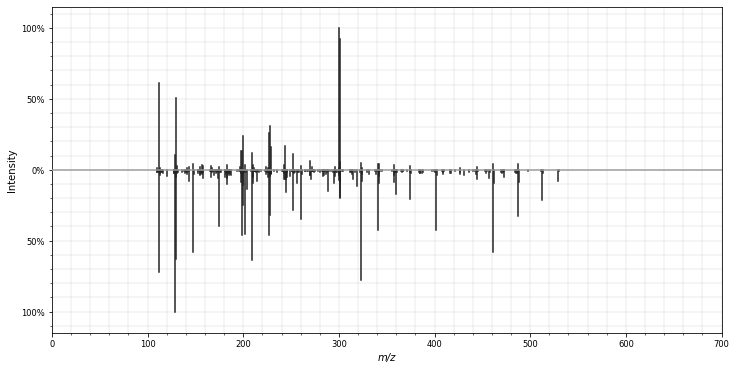

475 4
['mzspec:PXD000561:Adult_Monocytes_bRP_Elite_33_f01:scan:2558', 'mzspec:PXD000561:Adult_Monocytes_bRP_Elite_33_f04:scan:2876', 'mzspec:PXD000561:Adult_Monocytes_bRP_Elite_33_f02:scan:3177', 'mzspec:PXD000561:Adult_Monocytes_bRP_Elite_33_f03:scan:2707']
69578.89 37109.973


<ipython-input-80-33df3c1961cf>:7: RuntimeWarning: divide by zero encountered in double_scalars
  return abs( av_intensity /(mzs[1]-mzs[0]))


[129.08415 130.08351 143.11803 147.113   156.11333 157.12294 158.10152
 171.11292 175.11911 185.1203  197.12862 229.1433  236.66574 242.15726
 253.17867 270.17227 271.17087 288.20316 298.1998  300.16153 301.14722
 301.19843 324.20346 327.23016 342.21368 359.24023 360.24365 455.29794
 472.32413 473.32703 487.3203  494.30975 512.31934 529.34576 530.34814]
[120.08048  123.648544 124.91281  125.75117  127.51208  128.32161
 129.06583  129.10214  129.89577  130.08632  130.09723  131.6487
 133.09718  136.07549  139.05026  141.0659   141.10255  142.12282
 143.1179   147.113    148.74759  155.08162  156.11319  156.82294
 157.10843  157.13362  158.09242  161.8328   169.13354  170.06004
 171.11287  175.11899  180.12372  183.14906  185.12842  185.25095
 187.14417  191.80275  197.12834  201.64604  204.13478  207.47469
 211.1443   214.15482  221.41824  228.17047  229.12926  229.15428
 234.3038   236.6653   242.14983  246.18068  253.16608  253.19061
 254.14954  257.16055  260.19626  261.3521   266.16

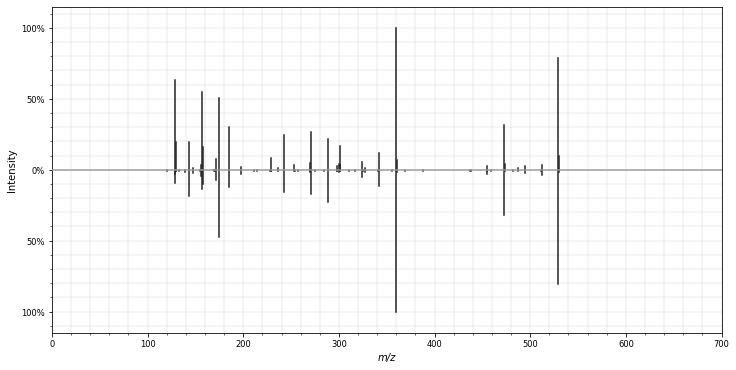

594 5
['mzspec:PXD000561:Adult_Frontalcortex_Gel_Elite_80_f04:scan:3124', 'mzspec:PXD000561:Adult_Frontalcortex_Gel_Elite_80_f04:scan:3036', 'mzspec:PXD000561:Adult_Frontalcortex_Gel_Elite_80_f05:scan:3073', 'mzspec:PXD000561:Adult_Frontalcortex_Gel_Elite_80_f05:scan:2989', 'mzspec:PXD000561:Adult_Frontalcortex_Gel_Elite_80_f06:scan:3133']
80459.86 48898.176


<ipython-input-80-33df3c1961cf>:7: RuntimeWarning: divide by zero encountered in double_scalars
  return abs( av_intensity /(mzs[1]-mzs[0]))


[124.07575 129.0907  130.09303 136.08076 157.11328 158.10532 159.10052
 167.09784 175.11914 185.10754 187.09015 215.10992 244.14546 272.15884
 300.18457 301.15765 302.13522 330.15643 359.20398 399.20126 487.30298]
[110.071304 112.03939  112.086975 112.112144 113.070915 114.055115
 114.102806 114.36711  115.0866   116.0707   117.10202  117.598175
 119.027626 119.04922  120.08088  123.97676  124.07585  125.07927
 125.55956  126.09153  127.08678  128.07085  129.06586  129.10246
 130.06526  130.08649  130.09767  130.10588  131.02753  133.09737
 136.0759   136.08705  136.58984  139.08691  140.08212  141.06621
 141.10268  142.78552  143.11824  143.6849   147.04424  147.11314
 148.44655  152.10739  154.12291  154.15248  155.08154  155.1179
 156.07649  156.10202  156.11357  157.0976   157.10884  157.13383
 158.09271  159.0769   159.09544  159.11311  164.85246  166.06136
 166.09782  167.0816   167.09306  167.11835  168.37155  169.0615
 169.09763  169.13405  170.06366  171.07579  171.10074  172.

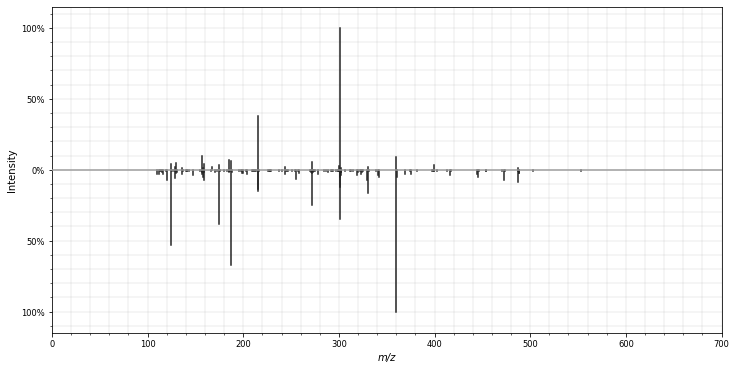

642 4
['mzspec:PXD000561:Fetal_Heart_bRP_Elite_19_f16:scan:760', 'mzspec:PXD000561:Fetal_Heart_bRP_Elite_20_f14:scan:1007', 'mzspec:PXD000561:Fetal_Heart_bRP_Elite_20_f14:scan:947', 'mzspec:PXD000561:Fetal_Heart_bRP_Elite_19_f16:scan:679']
9374.877 7083.386


<ipython-input-80-33df3c1961cf>:7: RuntimeWarning: divide by zero encountered in double_scalars
  return abs( av_intensity /(mzs[1]-mzs[0]))


[129.084   130.09293 141.08412 157.11627 169.07922 175.11906 186.1056
 226.13698 244.15144 272.15375 300.16586 301.1569  301.23438 303.19562
 416.26144]
[120.08117  120.55165  122.132935 124.03953  126.14834  127.00707
 127.05062  127.08658  129.06581  129.10223  130.08632  130.10576
 131.08185  136.07579  136.58759  140.08212  141.0659   141.10243
 143.11778  147.11292  152.03467  153.10263  155.08165  155.11827
 155.16441  156.07727  156.59303  157.10892  157.13358  158.09254
 158.35188  163.64195  164.9212   167.11848  169.06102  169.09769
 171.0884   171.11317  172.07202  172.10849  173.0927   175.119
 180.89479  183.11333  183.1503   185.12921  185.57773  186.08725
 186.12372  186.84476  194.09282  195.113    197.10425  197.12851
 198.08807  198.13275  199.1071   199.11467  200.14021  201.12411
 201.64494  204.13434  207.82404  208.6353   209.09265  209.1046
 210.08763  211.10799  212.10284  212.1395   214.11942  215.11418
 215.1394   216.44899  221.10408  222.08884  222.12526  22

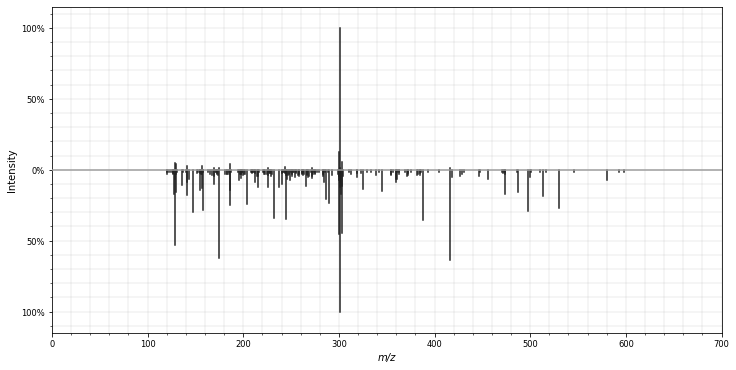

668 4
['mzspec:PXD000561:Adult_Adrenalgland_Gel_Elite_49_f12:scan:6753', 'mzspec:PXD000561:Adult_Adrenalgland_Gel_Elite_49_f12:scan:8251', 'mzspec:PXD000561:Adult_Adrenalgland_Gel_Elite_49_f13:scan:8213', 'mzspec:PXD000561:Adult_Adrenalgland_Gel_Elite_49_f13:scan:6657']
120407.44 101248.71


<ipython-input-80-33df3c1961cf>:7: RuntimeWarning: divide by zero encountered in double_scalars
  return abs( av_intensity /(mzs[1]-mzs[0]))


[110.086266 112.09636  113.08565  115.08654  126.09126  127.11567
 128.0947   129.10223  130.08272  131.08296  138.0914   147.11288
 155.10585  156.10564  169.12639  173.11378  175.11891  183.12848
 199.14418  201.11115  225.17421  227.1442   229.11827  242.17912
 243.17056  252.15253  253.17827  255.13634  257.66553  260.19684
 270.174    300.15152  301.15604  312.17484  342.16583  357.21338
 375.2237   401.25955  488.31393 ]
[112.11196  113.07087  115.086624 126.09135  127.1229   128.1071
 129.10225  130.08626  131.08139  138.09155  139.0868   141.10214
 147.11288  155.118    156.10179  169.13316  171.149    175.11885
 183.11255  183.1495   197.16469  199.1442   200.14761  201.12343
 226.11871  227.13904  229.11824  240.09802  242.18646  243.17079
 244.1292   245.16518  252.13414  252.17064  255.13396  257.66547
 260.19687  270.18124  280.12955  288.20294  298.14     300.13416
 300.1703   300.2532   301.12903  301.15176  301.17642  329.21826
 339.2041   340.1878   342.166    357.2144

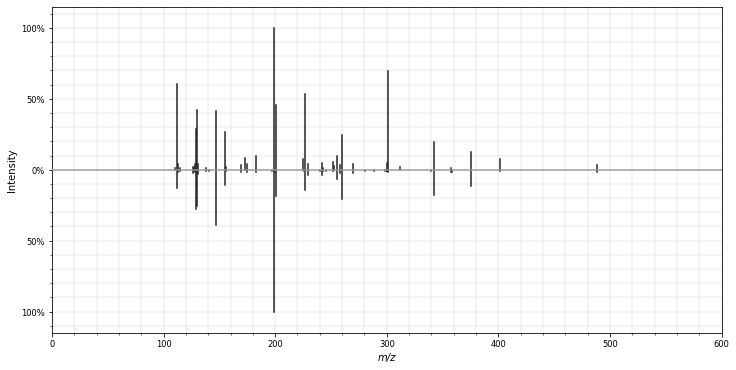

787 5
['mzspec:PXD000561:Adult_Liver_bRP_Elite_82_f11:scan:19560', 'mzspec:PXD000561:Adult_Liver_bRP_Elite_82_f12:scan:19279', 'mzspec:PXD000561:Adult_Liver_bRP_Elite_82_f10:scan:19347', 'mzspec:PXD000561:Adult_Liver_bRP_Elite_82_f23:scan:18954', 'mzspec:PXD000561:Adult_Liver_bRP_Elite_82_f22:scan:19290']
23290.264 27464.998


<ipython-input-80-33df3c1961cf>:7: RuntimeWarning: divide by zero encountered in double_scalars
  return abs( av_intensity /(mzs[1]-mzs[0]))


[175.11368 252.26868 269.26694 300.21686 300.28873 301.1194  301.19974
 322.18738]
[111.044205 112.08671  114.10264  115.08679  116.07047  120.08059
 126.12811  130.09763  131.08603  133.06512  143.0859   145.10172
 147.11726  149.06027  157.10144  157.10884  158.09248  159.08131
 159.11725  167.5979   171.11717  173.09583  175.11891  176.12222
 184.20589  185.09639  185.13307  189.10231  189.12802  190.09753
 195.11725  195.13881  196.10855  196.206    199.11221  210.22142
 213.12796  217.12369  217.15953  224.2017   231.1389   240.23312
 241.19606  244.68414  245.18579  252.2685   253.27179  255.17526
 255.21011  262.15573  263.1387   265.19495  268.26328  269.26688
 270.27017  273.1949   273.2221   273.69675  278.19775  283.0546
 283.1146   283.13245  283.16943  283.20547  283.2827   284.28787
 286.2527   287.15012  288.13535  300.0936   300.13962  300.15933
 300.2069   300.23123  300.2546   300.26996  300.29123  300.3102
 301.14374  301.1798   301.21478  301.31238  301.72684  301.9

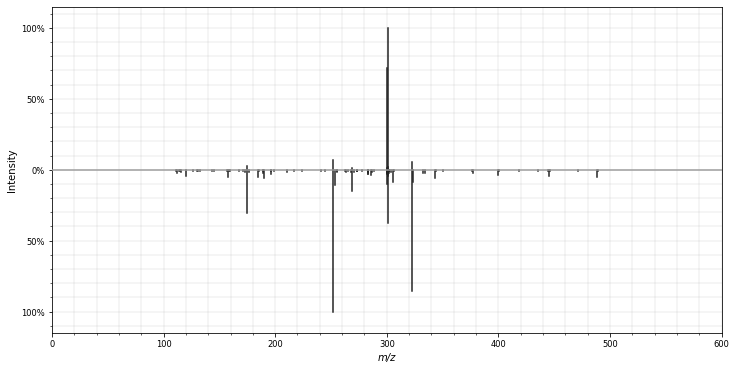

801 8
['mzspec:PXD000561:Adult_Gallbladder_bRP_Elite_53_f08:scan:1065', 'mzspec:PXD000561:Adult_Gallbladder_bRP_Elite_53_f07:scan:1375', 'mzspec:PXD000561:Adult_Gallbladder_bRP_Elite_53_f07:scan:712', 'mzspec:PXD000561:Adult_Gallbladder_bRP_Elite_53_f07:scan:863', 'mzspec:PXD000561:Adult_Gallbladder_bRP_Elite_53_f07:scan:790', 'mzspec:PXD000561:Adult_Gallbladder_bRP_Elite_53_f07:scan:1226', 'mzspec:PXD000561:Adult_Gallbladder_bRP_Elite_53_f07:scan:1299', 'mzspec:PXD000561:Adult_Gallbladder_bRP_Elite_53_f08:scan:1137']
31131.031 12530.487


<ipython-input-80-33df3c1961cf>:7: RuntimeWarning: divide by zero encountered in double_scalars
  return abs( av_intensity /(mzs[1]-mzs[0]))


[127.073586 129.08408  130.09164  155.09058  175.119    183.08824
 300.6514   301.15738 ]
[110.07103  111.07432  112.086716 113.07086  115.04984  115.08634
 116.07045  118.534515 124.2108   127.00631  127.049736 127.08651
 127.1099   129.06566  129.10211  129.16258  130.08617  130.09726
 130.1058   133.04285  133.93385  134.0689   135.89513  137.07083
 137.94371  137.94907  138.06633  138.27853  141.06581  141.10217
 143.0816   144.79602  145.06064  147.11284  147.1969   150.37886
 153.4079   154.09741  155.08145  155.09277  155.10078  157.10812
 158.0922   159.07623  169.06071  171.07635  171.11253  173.09201
 175.11884  176.11575  176.12198  179.48073  181.06111  181.09705
 182.09222  183.07637  183.09554  184.07924  185.10347  186.12344
 187.07127  187.10793  187.66022  194.0923   195.0552   195.09578
 197.10364  199.07101  199.10803  201.08707  204.1341   209.09207
 210.08734  210.35866  211.01039  211.07137  212.10239  213.0867
 214.13008  215.11304  219.58707  221.2453   222.1233

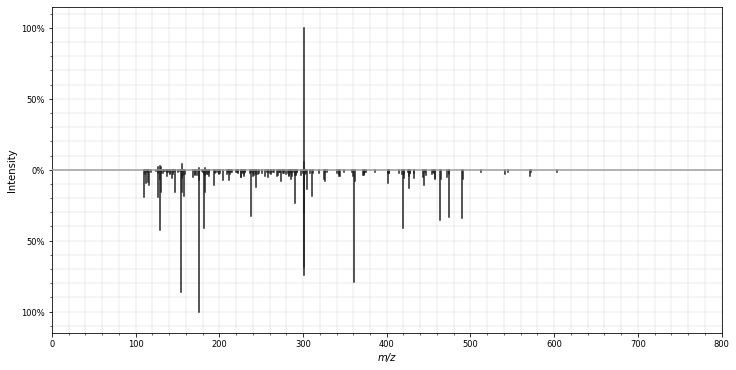

823 15
['mzspec:PXD000561:Adult_Heart_bRP_Elite_81_f12:scan:2667', 'mzspec:PXD000561:Adult_Heart_Gel_Elite_54_f10:scan:1999', 'mzspec:PXD000561:Adult_Heart_bRP_Elite_81_f10:scan:2893', 'mzspec:PXD000561:Adult_Heart_Gel_Elite_54_f14:scan:1023', 'mzspec:PXD000561:Adult_Heart_Gel_Elite_54_f08:scan:1499', 'mzspec:PXD000561:Adult_Heart_Gel_Elite_54_f06:scan:1842', 'mzspec:PXD000561:Fetal_Heart_bRP_Elite_20_f16:scan:1040', 'mzspec:PXD000561:Adult_Heart_Gel_Elite_54_f12:scan:1558', 'mzspec:PXD000561:Adult_Heart_Gel_Elite_54_f09:scan:1519', 'mzspec:PXD000561:Adult_Heart_Gel_Elite_54_f05:scan:1539', 'mzspec:PXD000561:Adult_Heart_bRP_Elite_81_f08:scan:2789', 'mzspec:PXD000561:Adult_Heart_Gel_Elite_54_f07:scan:1778', 'mzspec:PXD000561:Adult_Heart_Gel_Elite_54_f11:scan:1681', 'mzspec:PXD000561:Adult_Heart_Gel_Elite_54_f13:scan:1186', 'mzspec:PXD000561:Adult_Heart_bRP_Elite_81_f22:scan:2754']
133566.17 100156.13


<ipython-input-80-33df3c1961cf>:7: RuntimeWarning: divide by zero encountered in double_scalars
  return abs( av_intensity /(mzs[1]-mzs[0]))


KeyboardInterrupt: 

In [81]:
import spectrum_utils.plot as sup
import spectrum_utils.spectrum as sus
import matplotlib.pyplot as plt

import importlib
importlib.reload(ms_io)

for index, row in tqdm(cl_summary[mask].iterrows(), total=len(cl_summary[mask])):
    id = row['id']

    # Get the identifiers of the corresponding spectra
    curr_sps = cluster_labels[cluster_labels['cluster'] == id]
    print(id, len(curr_sps))

    # Load the bucket containing the spectra
    precursor_charge = curr_sps['precursor_charge'].iloc[0]
    mz_bucket = math.floor(curr_sps['precursor_mz'].iloc[0])

    print(curr_sps['identifier'].tolist())
    sps = ms_io.get_one_spectrum_from_pkl(
            '/media/maesk/WD/falcon/PXD000561/spectra',
            precursor_charge, mz_bucket, curr_sps['identifier'].tolist())
    print(max(sps[0].intensity), max(sps[1].intensity))
    sp_consensus = representative_spectrum(sps, 'consensus:%d' % (id,))

    print(sp_consensus.mz)
    print(sps[0].mz)

    fig, ax = plt.subplots(figsize=(12, 6))
    sup.mirror(sp_consensus,
               sps[0],
               ax=ax)
    plt.show()
    plt.close()